<a href="https://colab.research.google.com/github/s-choung/OC_Fine_Tuning_SA/blob/main/1_ptceox_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing OCP pretrained models
written by S.Choung 18th NovOct
This code is to evaluate finetuned OC models

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


## OCP installation

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

if not os.path.exists('ocp'):
     !git clone https://github.com/Open-Catalyst-Project/ocp.git
os.chdir('ocp')
!pip install -e .
!pip -q install  lmdb pymatgen==2023.5.10 ase==3.22.1 orjson e3nn==0.2.6 wandb
!pip install submitit

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ocp'...
remote: Enumerating objects: 11841, done.
remote: Counting objects: 100% (2729/2729), done.
remote: Compressing objects: 100% (734/734), done.
remote: Total 11841 (delta 2312), reused 2118 (delta 1995), pack-reused 9112
Receiving objects: 100% (11841/11841), 172.66 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (8165/8165), done.
Obtaining file:///content/ocp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable f

In [ ]:
import json,zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

from ase.io import read

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from ocpmodels.datasets import SinglePointLmdbDataset
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.models import CGCNN,SchNet
from ocpmodels.datasets import data_list_collater
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
if torch.cuda.is_available():
    device = torch.device("cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


## load some useful utillities
 code taken from https://open-catalyst-project.github.io/tutorial/fine-tuning/fine-tuning-oxides.html

In [ ]:
# @title
import urllib
import os
from pathlib import Path
import requests
# @title
import ocpmodels as om
from pathlib import Path
import subprocess
import sys
import numba
import numpy as np
import ase
import e3nn
import pymatgen.core as pc
import torch
import torch.cuda as tc
import torch_geometric as tg
import platform
import psutil

def ocp_root():
    """Return the root directory of the installed ocp package."""
    return Path(om.__file__).parent.parent

def ocp_main():
    """Return the path to ocp main.py"""
    return ocp_root() / "main.py"

def describe_ocp():
    """Print some system information that could be useful in debugging."""
    print(sys.executable, sys.version)
    print(f'ocp is installed at {ocp_root()}')

    commit_hash = (
            subprocess.check_output(
                    [
                        "git",
                        "-C",
                        om.__path__[0],
                        "describe",
                        "--always",
                    ]
                )
                .strip()
                .decode("ascii")
            )
    print(f'ocp repo is at git commit: {commit_hash}')
    print(f'numba: {numba.__version__}')
    print(f'numpy: {np.version.version}')
    print(f'ase: {ase.__version__}')
    print(f'e3nn: {e3nn.__version__}')
    print(f'pymatgen: {pc.__version__}')
    print(f'torch: {torch.version.__version__}')
    print(f'torch.version.cuda: {torch.version.cuda}')
    print(f'torch.cuda: is_available: {tc.is_available()}')
    if tc.is_available():
        print('  __CUDNN VERSION:', torch.backends.cudnn.version())
        print('  __Number CUDA Devices:', torch.cuda.device_count())
        print('  __CUDA Device Name:',torch.cuda.get_device_name(0))
        print('  __CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
    print(f'torch geometric: {tg.__version__}')
    print()
    print(f'Platform: {platform.platform()}')
    print(f'  Processor: {platform.processor()}')
    print(f'  Virtual memory: {psutil.virtual_memory()}')
    print(f'  Swap memory: {psutil.swap_memory()}')
    print(f'  Disk usage: {psutil.disk_usage("/")}')
checkpoints = {
    # Open Catalyst 2020 (OC20)
    'CGCNN 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_200k.pt',
    'CGCNN 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_2M.pt',
    'CGCNN 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_20M.pt',
    'CGCNN All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_all.pt',
    'DimeNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_200k.pt',
    'DimeNet 2M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_2M.pt',
    'SchNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_200k.pt',
    'SchNet 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_2M.pt',
    'SchNet 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_20M.pt',
    'SchNet All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_all_large.pt',
    'DimeNet++ 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_200k.pt',
    'DimeNet++ 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_2M.pt',
    'DimeNet++ 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_20M.pt',
    'DimeNet++ All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_all.pt',
    'SpinConv 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/spinconv_force_centric_2M.pt',
    'SpinConv All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/spinconv_force_centric_all.pt',
    'GemNet-dT 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/gemnet_t_direct_h512_2M.pt',
    'GemNet-dT All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt',
    'PaiNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_05/s2ef/painn_h512_s2ef_all.pt',
    'GemNet-OC 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_2M.pt',
    'GemNet-OC All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_all.pt',
    'GemNet-OC All+MD'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt',
    'GemNet-OC-Large All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_large_s2ef_all_md.pt',
    'SCN 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t1_b1_s2ef_2M.pt',
    'SCN-t4-b2 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t4_b2_s2ef_2M.pt',
    'SCN All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_all_md_s2ef.pt',
    'eSCN-L4-M2-Lay12 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l4_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_all_md_s2ef.pt',
    'eSCN-L6-M3-Lay20 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt',
    'EquiformerV2 (83M) 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_83M_2M.pt',
    'EquiformerV2 (31M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_31M_ec4_allmd.pt',
    'EquiformerV2 (153M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_153M_ec4_allmd.pt',
    # Open Catalyst 2022 (OC22)
    'GemNet-dT OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gndt_oc22_all_s2ef.pt',
    'GemNet-OC OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt',
    'GemNet-OC OC20+OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_05/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC OC20->OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_finetune_all_s2ef.pt',
    'equiformer' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_10/oc22/s2ef/eq2_121M_e4_f100_oc22_s2ef.pt',
    'pt_ceo2_ce7_ep200' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/fine-tuning/checkpoints/2023-11-14-16-21-20-lr_5e-07_epochs_200/checkpoint.pt',
    'pt_ceo2_ce5_ep100_add' : '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/additional_data_training/2023-11-16-02-42-08-lr_0.0005_epochs_100/checkpoint.pt',
                }

def list_checkpoints():
    """List checkpoints that are available to download."""
    print('See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.')
    for key in checkpoints:
        print(key)
    print('Copy one of these keys to get_checkpoint(key) to download it.')


def get_checkpoint(key):
    """Download a checkpoint.
    key: string in checkpoints.
    Returns name of checkpoint that was saved.
    """
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception('No url found for {key}')
    print('url',url)
    pt = Path(urllib.parse.urlparse(url).path).name
    print('pt',pt)

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt
from pathlib import Path
import numpy as np
from ase.db import connect

def train_test_val_split(ase_db, ttv=(0.8, 0.1, .1), files=('train.db', 'test.db', 'val.db'), seed=42):
    """Split an ase db into train, test and validation dbs.

    ase_db: path to an ase db containing all the data.
    ttv: a tuple containing the fraction of train, test and val data. This will be normalized.
    files: a tuple of filenames to write the splits into. An exception is raised if these exist.
           You should delete them first.
    seed: an integer for the random number generator seed

    Returns the absolute path to files.
    """

    for db in files:
        if os.path.exists(db):
            raise Exception('{db} exists. Please delete it before proceeding.')

    src = connect(ase_db)
    N = src.count()

    ttv = np.array(ttv)
    ttv /= ttv.sum()

    train_end = int(N * ttv[0])
    test_end = train_end + int(N * ttv[1])

    train = connect(files[0])
    test = connect(files[1])
    val = connect(files[2])

    ids = np.arange(1, N + 1)
    rng = np.random.default_rng(seed=42)
    rng.shuffle(ids)

    for _id in ids[0:train_end]:
        row = src.get(id=int(_id))
        train.write(row.toatoms())

    for _id in ids[train_end:test_end]:
        row = src.get(id=int(_id))
        test.write(row.toatoms())

    for _id in ids[test_end:]:
        row = src.get(id=int(_id))
        val.write(row.toatoms())

    return [Path(f).absolute() for f in files]
# @title
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper
import torch
import os
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
from io import StringIO
import sys
import contextlib

def generate_yml_config(checkpoint_path, yml='run.yml', delete=(), update=()):
    """Generate a yml config file from an existing checkpoint file.

    checkpoint_path: string to path of an existing checkpoint
    yml: name of file to write to.
    pop: list of keys to remove from the config
    update: dictionary of key:values to update

    Use a dot notation in update.

    Returns an absolute path to the generated yml file.
    """

    # You can't just read in the checkpoint with torch. The calculator does some things to it.
    # Rather than recreate that here I just reuse the calculator machinery. I don't want to
    # see the output though, so I capture it.

    with contextlib.redirect_stdout(StringIO()) as _:
        config = OCPCalculator(checkpoint_path=checkpoint_path).config # there seems an parameter checkpoint changed in OCPcalculator (s.choung)

    for key in delete:
        if key in config and len(key.split('.')) == 1:
            del config[key]
        else:
            keys = key.split('.')
            if keys[0] in config:
                d = config[keys[0]]
            else:
                continue
            if isinstance(d, dict):
                for k in keys[1:]:
                    if isinstance(d[k], dict):
                        d = d[k]
                    else:
                        if k in d:
                            del d[k]

    def nested_set(dic, keys, value):
        for key in keys[:-1]:
            dic = dic.setdefault(key, {})
        dic[keys[-1]] = value

    for _key in update:
        keys = _key.split('.')
        nested_set(config, keys, update[_key])


    out = dump(config)
    with open(yml, 'wb') as f:
        f.write(out.encode('utf-8'))

    return Path(yml).absolute()

## Calculator setting



In [ ]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
from ase.io import Trajectory
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy
import ase.io
import ase.calculators.singlepoint
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import json

gemnet = get_checkpoint('GemNet-OC OC20+OC22')
pt_ceo2_ce7_ep200 = checkpoints.get('pt_ceo2_ce7_ep200')
pt_ceo2_ce5_ep100_add = checkpoints.get('pt_ceo2_ce5_ep100_add')

calc_gemnet = OCPCalculator(checkpoint_path=os.path.expanduser(gemnet), cpu=False)
calc_pt_ceo2_ce7_ep200 = OCPCalculator(checkpoint_path=pt_ceo2_ce7_ep200, cpu=False)
calc_pt_ceo2_ce5_ep100_add = OCPCalculator(checkpoint_path=pt_ceo2_ce5_ep100_add, cpu=False)


url https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt
pt gnoc_oc22_oc20_all_s2ef.pt


In [ ]:
def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax,steps=500)
    return atoms.get_total_energy()
def calculate_energy(atoms, calculator, fmax=0.05):
    atoms.calc = calculator
    E = get_opt_energy(atoms, fmax)
    return E

## Evaluation EOS

In [ ]:
import os
import re
from ase.io.vasp import read_vasp_xdatcar, read_vasp

#current_path = os.getcwd()
#contcar_bulk = os.path.join(current_path, 'xdatcars2')
bulk_ceo2=read_vasp('/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/ceo2_bulk')

In [ ]:
bulk_ceo2

Atoms(symbols='Ce4O8', pbc=True, cell=[[5.571347165385157, -2.67218523e-08, 8.628682357e-07], [-2.57860645e-08, 5.57134344779467, -2.1272770235e-06], [8.631290046e-07, -2.1273477123e-06, 5.57134526907032]])

In [ ]:
import numpy as np

cell_matrix = np.array([[5.571347165385157, -2.67218523e-08, 8.628682357e-07],
                        [-2.57860645e-08, 5.57134344779467, -2.1272770235e-06],
                        [8.631290046e-07, -2.1273477123e-06, 5.57134526907032]])

# Calculate the volume using the determinant of the cell matrix
volume = np.linalg.det(cell_matrix)

print(f"The volume of the structure is {volume} cubic Angstroms.")


The volume of the structure is 172.93393608763708 cubic Angstroms.


In [ ]:
from ase.build import bulk
import numpy as np


cohesive_energy_list = []
search_space = np.linspace(140, 200, 20)
calculators = [calc_gemnet, calc_pt_ceo2_ce7_ep200]
for calc in calculators:
    coh_cal_list=[]
    for volume in search_space:
        a = (volume / bulk_ceo2.get_volume())**(1/3)
        temp = bulk_ceo2.copy()
        temp.set_cell(temp.cell * a, scale_atoms=True)
        tags = np.ones(len(bulk_ceo2))
        temp.set_tags(tags)
        temp.set_calculator(calc)
        coh_energy = get_opt_energy(temp, fmax=0.05)
        coh_cal_list.append(coh_energy)
    cohesive_energy_list.append(coh_cal_list)
print(cohesive_energy_list)


       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -102.671562        0.0140
       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -103.473373        0.0109
       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -104.178673        0.0056
       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -104.629166        0.0103
       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -104.869385        0.0080
       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -104.911285        0.0134
       Step     Time          Energy         fmax
LBFGS:    0 05:30:07     -104.941315        0.0047
       Step     Time          Energy         fmax
LBFGS:    0 05:30:08     -104.882614        0.0039
       Step     Time          Energy         fmax
LBFGS:    0 05:30:08     -104.769287        0.0044
       Step     Time          Energy         fmax
LBFGS:    0 05:30:08     -104.652695     

In [ ]:
# ReaxFF data
pbe_u_data = {
    30.48457296769739: 2.9657696878726334,
    32.405455670947376: 1.765805723449342,
    34.67941444218334: 0.8701920273304085,
    36.83530513138497: 0.3516648662884996,
    39.249027637351155: 0.06099144952144808,
    41.58594144504991: -0.01604608660268525,
    44.178572551330156: 0.06773989514494794,
    46.77553176306918: 0.2887268199357971,
    49.62706525883853: 0.6343037013260742,
    52.48102457685677: 1.0567791480065645,
    55.50405137093412: 1.5417503543197995
}

# ReaxFF data
reaxff_data = {
    30.590003061134986: 4.044856117323597,
    32.11011702441683: 2.8047005860686895,
    33.47154852365568: 1.7254010740104042,
    35.013106937337135: 0.9741790118666982,
    36.56592126163559: 0.4795917117904098,
    38.32902920335208: 0.16114575627351257,
    40.22525985116165: 0.022791926816475794,
    42.04746887068385: 0.0,
    43.73655895764621: 0.06397853285773802,
    45.66019929315988: 0.20417409811103582,
    47.250675276242106: 0.35833838500598514,
    49.16801291276326: 0.6172502048533923,
    51.25326415381616: 0.9257760086479729,
    53.341804837713184: 1.3093011092881186,
    55.349739616872824: 1.7444196816046325
}


In [ ]:
import numpy as np

# New PBE+U data in the format of lattice constant vs energy.
pbe_u_raw_data = [
    (5.19, -93.57),
    (5.34, -96.57),
    (5.43, -97.63),
    (5.47, -97.91),
    (5.52, -98.12),
    (5.57, -98.20),
    (5.61, -98.19),
    (5.66, -98.06),
    (5.69, -97.92),
    (5.74, -97.63),
    (5.77, -97.42),
    (5.85, -96.65)
]

# Calculate energy per atom for all data points
energy_per_atom_list = [energy / 4 for _, energy in pbe_u_raw_data]
# Find the minimum energy per atom to calculate relative energies
min_energy = np.min(energy_per_atom_list)

# Process the data to match the unit and per-atom value
pbe_u_processed_data = {}
for a, energy in pbe_u_raw_data:
    volume_per_atom = (a ** 3) / 4  # Convert lattice constant to volume per atom
    energy_per_atom = energy / 4    # Convert total energy to energy per atom
    relative_energy = energy_per_atom - min_energy
    pbe_u_processed_data[volume_per_atom] = relative_energy

pbe_u_processed_data



{34.94958975000001: 1.1575000000000024,
 38.068326: 0.4075000000000024,
 40.02575174999999: 0.14250000000000185,
 40.916830749999995: 0.07250000000000156,
 42.04915199999999: 0.019999999999999574,
 43.20217325000001: 0.0,
 44.13962025000001: 0.002500000000001279,
 45.330374000000006: 0.03500000000000014,
 46.05500225000001: 0.07000000000000028,
 47.27980600000001: 0.14250000000000185,
 48.02500824999999: 0.19500000000000028,
 50.05040624999999: 0.3874999999999993}

In [ ]:
cohesive_energy_list_np = [np.array(energy_list)/4 for energy_list in np.array(cohesive_energy_list)]
print(cohesive_energy_list_np)

[array([-25.66789055, -25.86834335, -26.0446682 , -26.15729141,
       -26.21734619, -26.22782135, -26.23532867, -26.22065353,
       -26.19232178, -26.16317368, -26.12714386, -26.07722855,
       -25.9833889 , -25.8834877 , -25.75208282, -25.63145256,
       -25.49983788, -25.36210632, -25.21468735, -25.06176949]), array([-24.14525223, -24.15936661, -24.1787262 , -24.20730019,
       -24.23741722, -24.2564373 , -24.27627373, -24.29376984,
       -24.31119347, -24.32408142, -24.32882881, -24.32613373,
       -24.31463432, -24.29933548, -24.27183723, -24.24211693,
       -24.20685005, -24.1656208 , -24.1256218 , -24.07910156])]


Get Bulk moduli

In [ ]:
savepath='/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/evaluations'
# Font and color settings
fs = 12  # Font size for ticks
fss = 12  # Font size for legend
fsl = 15  # Font size for labels
font_path = '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/utilitis/seguisb.ttf'
font_properties = fm.FontProperties(fname=font_path, size=fsl)
colors = ['#EA466C', '#E49E02', '#02DAA2', '#00b3fe', '#0E8BB3', '#120458']


NameError: ignored

GemNet Bulk Modulus (B0): 184.72 GPa
FT-GemNet Bulk Modulus (B0): 69.66 GPa
reaxff Bulk Modulus (B0): 209.97 GPa
PBE+U Bulk Modulus (B0): 155.58 GPa


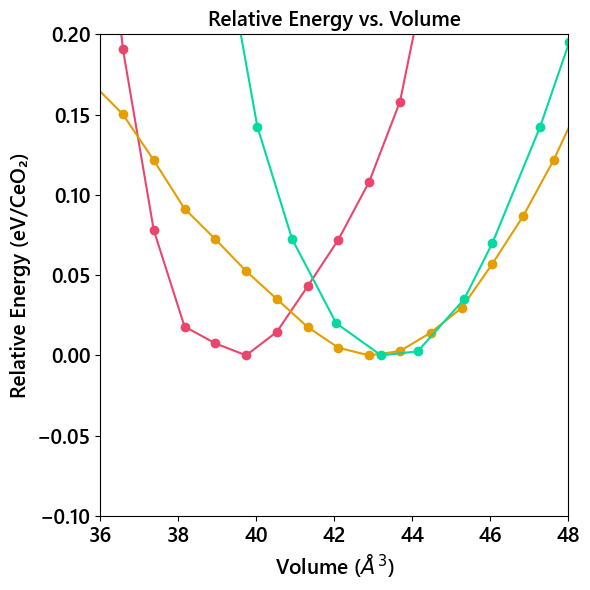

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase.eos import EquationOfState
from ase.units import kJ
import matplotlib.font_manager as fm


def fit_eos(volumes, energies, exclude=2):
    volumes_fit = volumes[exclude:-exclude]
    energies_fit = energies[exclude:-exclude]
    eos = EquationOfState(volumes_fit, energies_fit, eos='birchmurnaghan')
    v0, e0, B = eos.fit()
    B_GPa = B / kJ * 1.0e24  # Conversion to GPa from eV/Angstrom^3 to J/m^3
    x = np.linspace(min(eos.v), max(eos.v), 100)
    y = eos.func(x, *eos.eos_parameters)
    return  B_GPa, x, y

# Font and color settings
fs = 12  # Font size for ticks
fss = 12  # Font size for legend
fsl = 15  # Font size for labels
font_path = '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/utilitis/seguisb.ttf'
font_properties = fm.FontProperties(fname=font_path, size=fsl)
colors = ['#EA466C', '#E49E02', '#02DAA2', '#00b3fe', '#0E8BB3', '#120458']



# Assuming 'cohesive_energy_list_np', 'reaxff_data', and 'pbe_u_processed_data' are defined elsewhere
search_space = np.linspace(140, 200, 20) / 4
datasets = {
    'GemNet': {'volumes': search_space, 'energies': cohesive_energy_list_np[0]},
    'FT-GemNet': {'volumes': search_space, 'energies': cohesive_energy_list_np[1]}
}

plt.figure(figsize=(6, 6))
for i, (name, data) in enumerate(datasets.items()):
    volumes = data['volumes']
    energies = data['energies']
    min_energy_index = np.argmin(energies)
    V0_initial_guess = volumes[min_energy_index]
    min_energy = energies[min_energy_index]
    relative_energies = [energy - min_energy for energy in energies]

    plt.plot(volumes, relative_energies, marker='o', label=name, color=colors[i])
    B_GPa, x, y = fit_eos(volumes, relative_energies, 2)
    # Uncomment below if you want to plot the EOS fit
    # plt.plot(x, y, linestyle='-', color=colors[i], alpha=0.3)
    print(f"{name} Bulk Modulus (B0): {B_GPa:.2f} GPa")



#plt.plot(list(reaxff_data.keys()), list(reaxff_data.values()), marker='o', label='ReaxFF Briqvist etal. JPCC 2015',color='gray')
B_GPa, x, y = fit_eos(list(reaxff_data.keys()), list(reaxff_data.values()),3)
#plt.plot(x, y, label='ReaxFF Briqvist etal. JPCC 2015', linestyle='-',color='gray',alpha=0.3)
print(f"reaxff Bulk Modulus (B0): {B_GPa:.2f} GPa")

plt.plot(list(pbe_u_processed_data.keys()), list(pbe_u_processed_data.values()), marker='o', label='PBE+U',color=colors[2])
B_GPa, x, y = fit_eos(list(pbe_u_processed_data.keys()), list(pbe_u_processed_data.values()),1)
#plt.plot(x, y, label='PBE+U this work', linestyle='-',color='red',alpha=0.3)
print(f"PBE+U Bulk Modulus (B0): {B_GPa:.2f} GPa") ###EOS fit으로 fitting하거나 그냥 선을 잇거나 한가지만혀

# Add other data and EOS fits if necessary
def subscript(text):
    subscripts = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return text.translate(subscripts)

plt.xlim(36, 48)
plt.ylim(-0.1, 0.2)
plt.xlabel('Volume ($\AA^{3}$)', fontproperties=font_properties)
plt.ylabel(subscript('Relative Energy (eV/CeO2)'), fontproperties=font_properties)
plt.title('Relative Energy vs. Volume', fontproperties=font_properties)
#plt.legend(prop=font_properties)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.yticks(fontproperties=font_properties)
plt.xticks(fontproperties=font_properties)
plt.tight_layout()
plt.savefig(savepath+'/bulk.png',dpi=1000)
plt.show()



## Surface energy evaluation

#### Data get

In [ ]:
!unzip /content/drive/MyDrive/0_doctoral_project/1_pt_ceox/contcars.zip
!unzip /content/drive/MyDrive/0_doctoral_project/1_pt_ceox/additional.zip
!unzip /content/drive/MyDrive/0_doctoral_project/1_pt_ceox/energy_force.zip

Archive:  /content/drive/MyDrive/0_doctoral_project/1_pt_ceox/contcars.zip
   creating: contcars/
  inflating: contcars/0_CONTCAR      
  inflating: contcars/1_CONTCAR      
  inflating: contcars/2_CONTCAR      
  inflating: contcars/3_CONTCAR      
  inflating: contcars/4_CONTCAR      
  inflating: contcars/5_CONTCAR      
  inflating: contcars/6_CONTCAR      
  inflating: contcars/7_CONTCAR      
  inflating: contcars/9_CONTCAR      
  inflating: contcars/10_CONTCAR     
  inflating: contcars/11_CONTCAR     
  inflating: contcars/12_CONTCAR     
  inflating: contcars/13_CONTCAR     
  inflating: contcars/14_CONTCAR     
  inflating: contcars/15_CONTCAR     
  inflating: contcars/16_CONTCAR     
  inflating: contcars/17_CONTCAR     
  inflating: contcars/18_CONTCAR     
  inflating: contcars/19_CONTCAR     
  inflating: contcars/20_CONTCAR     
  inflating: contcars/21_CONTCAR     
  inflating: contcars/22_CONTCAR     
  inflating: contcars/23_CONTCAR     
  inflating: contcars/24_CON

In [ ]:
import os
from ase.io.vasp import read_vasp

def read_contcars(folder_path,contcar_path):
    contcars_files = [f for f in os.listdir(contcar_path) if f.endswith('_CONTCAR')]
    contcar_dict = {}
    for file in contcars_files:
        identifier = file.split('_')[0]  # Assuming the file name format is 'number_CONTCAR'
        contcar_atoms = read_vasp(os.path.join(contcar_path, file))
        contcar_dict[identifier] = contcar_atoms
    return contcar_dict

def read_energies(energy_path, contcar_dict):
    energy_values = {}
    for filename in os.listdir(energy_path):
        if filename.endswith('.dat'):
            identifier = filename.split('.')[0]  # Assuming the file name format is 'number.dat'
            file_path = os.path.join(energy_path, filename)
            with open(file_path, 'r') as file:
                last_line = file.readlines()[-1]
                energy = float(last_line.split()[2])
                if identifier in contcar_dict:
                    energy_values[identifier] = energy
    return energy_values

# Assuming the following paths
folder_path = os.getcwd()


contcar_path = '/content/ocp/contcars'
energy_path = '/content/ocp/energy_force'
contcar_dict = read_contcars(folder_path,contcar_path)
energy_dict = read_energies(energy_path, contcar_dict)

add_contcar_path = '/content/ocp/additional/add_contcars'
add_energy_path = '/content/ocp/additional/add_energy_force'
add_contcar_dict = read_contcars(folder_path,add_contcar_path)
add_energy_dict = read_energies(add_energy_path, add_contcar_dict)

def merge_contcar_and_energy(contcar_dict, energy_dict):
    structure_energy_dict = {}
    for identifier in contcar_dict:
        if identifier in energy_dict:
            structure_energy_dict[identifier] = {
                'atoms': contcar_dict[identifier],
                'dft_energy': energy_dict[identifier]
            }
    return structure_energy_dict

# Merge CONTCAR and energy data
structure_energy_dict = merge_contcar_and_energy(contcar_dict, energy_dict)
add_structure_energy_dict = merge_contcar_and_energy(add_contcar_dict, add_energy_dict)

print(structure_energy_dict)
print(add_structure_energy_dict)


{'13': {'atoms': Atoms(symbols='Ce16O32Pt', pbc=True, cell=[10.966666666666667, 5.483333333333333, 31.079166666641342], constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 32, 33, 34, 35, 36, 37])), 'dft_energy': -385.130324}, '17': {'atoms': Atoms(symbols='Ce28O56', pbc=True, cell=[[15.509208734024943, 0.0, 0.0], [-3.8773021835062353, 6.715684378130547, 0.0], [0.0, 0.0, 27.0]], constraint=FixAtoms(indices=[0, 1, 2, 3, 12, 13, 14, 15, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])), 'dft_energy': -675.302721}, '14': {'atoms': Atoms(symbols='Ce16O33Pt', pbc=True, cell=[10.966666666666667, 5.483333333333333, 31.079166666641342], constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 33, 34, 35, 36, 37, 38])), 'dft_energy': -390.567379}, '2': {'atoms': Atoms(symbols='Ce16O33Pt', pbc=True, cell=[[7.754604367012472, 0.0, 0.0], [-3.8773021835062353, 6.715684378130547, 0.0], [0.0, 0.0, 27.0]],

#### MLP calculation

In [ ]:
def status(proceed):
    num = int(proceed/5)
    return '🟩'*num+'⬜️'*(20-num)
#proceed = round((i+1) / len(selected_names) * 100, 2)
#print(status(proceed))

In [ ]:
def calculate_bulk_energies(add_dict, calculator, energy_results_dict):
    for identifier, structure_info in add_dict.items():
        if identifier not in energy_results_dict:  # Process only if not already done
            atom = structure_info['atoms']
            tags = np.ones(len(atom))
            atom.set_tags(tags)
            atom.set_calculator(calculator)
            tot_energy = get_opt_energy(atom, fmax=0.05)  # Adjust fmax as needed
            energy_results_dict[identifier] = tot_energy

energy_results_dict = {}  # Dictionary to store the results
calculators = [calc_pt_ceo2_ce7_ep200]
calculator_names = ["ft_e7_ep200"]

for i, calc in enumerate(calculators):
    calc_name = calculator_names[i]
    calculate_bulk_energies(add_structure_energy_dict, calc, energy_results_dict)
    for identifier in add_structure_energy_dict:
        add_structure_energy_dict[identifier][calc_name + '_energy'] = energy_results_dict[identifier]

# Print results
for identifier in add_structure_energy_dict:
    print(f"Identifier: {identifier}, Data: {add_structure_energy_dict[identifier]}")


       Step     Time          Energy         fmax
LBFGS:    0 05:32:16     -372.318420        1.1531
LBFGS:    1 05:32:16     -372.414703        0.9914
LBFGS:    2 05:32:16     -372.800934        0.7356
LBFGS:    3 05:32:16     -372.832642        0.6872
LBFGS:    4 05:32:16     -372.889893        0.2879
LBFGS:    5 05:32:17     -372.888580        0.2707
LBFGS:    6 05:32:17     -372.883362        0.1450
LBFGS:    7 05:32:17     -372.894562        0.1002
LBFGS:    8 05:32:17     -372.915070        0.0752
LBFGS:    9 05:32:17     -372.924530        0.0835
LBFGS:   10 05:32:17     -372.903076        0.0852
LBFGS:   11 05:32:17     -372.893250        0.0747
LBFGS:   12 05:32:17     -372.888611        0.0762
LBFGS:   13 05:32:17     -372.886200        0.0578
LBFGS:   14 05:32:17     -372.887787        0.0641
LBFGS:   15 05:32:18     -372.890594        0.0411
       Step     Time          Energy         fmax
LBFGS:    0 05:32:18     -374.805603        0.5557
LBFGS:    1 05:32:18     -374.849

In [ ]:
from ase import Atoms
from ase.io.vasp import write_vasp

for identifier, data in add_structure_energy_dict.items():
    if isinstance(data['atoms'], Atoms):
        print(f"Identifier: {identifier}, Atoms: {data['atoms']}")
        #print(data['atoms'].get_total_energy())
        #visual(data['atoms'], f'./ini_', (100, 100), 1)
        print(data['atoms'].symbols)
        write_vasp(f'/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/pt_ceox_evaluation_data/add_warm_start/ft_relaxed_{identifier}',data['atoms'])

Identifier: 13, Atoms: Atoms(symbols='Ce16O31', pbc=True, cell=[[5.5713448524, 0.0, 0.0], [-5.571336162, 12.4579050921, 0.0], [0.0, -2.491595805, 29.8989832441]], tags=..., constraint=FixAtoms(indices=[8, 9, 10, 11, 12, 13, 14, 15, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]), calculator=OCPCalculator(...))
Ce16O31
Identifier: 8, Atoms: Atoms(symbols='Ce16O31', pbc=True, cell=[11.14441270360164, 7.8803586320414425, 16.04698099759775], tags=..., constraint=FixAtoms(indices=[2, 3, 6, 7, 10, 11, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]), calculator=OCPCalculator(...))
Ce16O31
Identifier: 14, Atoms: Atoms(symbols='Ce16O31', pbc=True, cell=[[5.5713448524, 0.0, 0.0], [-5.571336162, 12.4579050921, 0.0], [0.0, -2.491595805, 29.8989832441]], tags=..., constraint=FixAtoms(indices=[8, 9, 10, 11, 12, 13, 14, 15, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]), calculator=OCPCalculator(...))
Ce16O31
Identifier: 2, Atoms: Atoms(symb

In [ ]:
def calculate_energies(structure_dict, calculator):
    energy_dict = {}
    for identifier, structure_info in structure_dict.items():
        atom = structure_info['atoms'].copy()
        tags = np.ones(len(atom))
        atom.set_tags(tags)
        atom.set_calculator(calculator)
        tot_energy = get_opt_energy(atom, fmax=0.05)  # Adjust fmax as needed
        energy_dict[identifier] = tot_energy
    return energy_dict

calculators = [calc_gemnet, calc_pt_ceo2_ce7_ep200]
calculator_names = ["gemnet", "ft_e7_ep200"]

for i,calc in enumerate(calculators):
    calc_name = calculator_names[i]

    structure_energy_results = calculate_energies(structure_energy_dict, calc)
    add_structure_energy_results = calculate_energies(add_structure_energy_dict, calc)

    for identifier in structure_energy_dict:
      structure_energy_dict[identifier][calc_name + '_energy'] = structure_energy_results[identifier]
    for identifier in add_structure_energy_dict:
        add_structure_energy_dict[identifier][calc_name + '_energy'] = add_structure_energy_results[identifier]
    print(f"Completed calculations with {calc_name}")

for identifier in add_structure_energy_dict:
    print(f"Identifier: {identifier}, Data: {add_structure_energy_dict[identifier]}")


       Step     Time          Energy         fmax
LBFGS:    0 05:32:52     -413.406647        0.6878
LBFGS:    1 05:32:52     -413.470581        0.6099
LBFGS:    2 05:32:53     -413.618073        0.6138
LBFGS:    3 05:32:53     -413.660065        0.6049
LBFGS:    4 05:32:53     -413.732117        0.3196
LBFGS:    5 05:32:53     -413.780853        0.2567
LBFGS:    6 05:32:53     -413.825958        0.2136
LBFGS:    7 05:32:53     -413.842041        0.3256
LBFGS:    8 05:32:53     -413.883026        0.2803
LBFGS:    9 05:32:53     -413.875336        0.1816
LBFGS:   10 05:32:53     -413.851074        0.1274
LBFGS:   11 05:32:53     -413.807678        0.0850
LBFGS:   12 05:32:53     -413.750854        0.1386
LBFGS:   13 05:32:54     -413.750854        0.2031
LBFGS:   14 05:32:54     -413.761688        0.1513
LBFGS:   15 05:32:54     -413.752533        0.1232
LBFGS:   16 05:32:54     -413.781281        0.0766
LBFGS:   17 05:32:54     -413.823608        0.0402
       Step     Time          En

In [ ]:
for identifier in structure_energy_dict:
    print(f"Identifier: {identifier}, Data: {structure_energy_dict[identifier]}")
print("======================================================================")
for identifier in add_structure_energy_dict:
    print(f"Identifier: {identifier}, Data: {add_structure_energy_dict[identifier]}")

Identifier: 13, Data: {'atoms': Atoms(symbols='Ce16O32Pt', pbc=True, cell=[10.966666666666667, 5.483333333333333, 31.079166666641342], constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 32, 33, 34, 35, 36, 37])), 'dft_energy': -385.130324, 'gemnet_energy': -413.8236083984375, 'ft_e7_ep200_energy': -385.0771789550781}
Identifier: 17, Data: {'atoms': Atoms(symbols='Ce28O56', pbc=True, cell=[[15.509208734024943, 0.0, 0.0], [-3.8773021835062353, 6.715684378130547, 0.0], [0.0, 0.0, 27.0]], constraint=FixAtoms(indices=[0, 1, 2, 3, 12, 13, 14, 15, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])), 'dft_energy': -675.302721, 'gemnet_energy': -724.3656005859375, 'ft_e7_ep200_energy': -675.28662109375}
Identifier: 14, Data: {'atoms': Atoms(symbols='Ce16O33Pt', pbc=True, cell=[10.966666666666667, 5.483333333333333, 31.079166666641342], constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 33, 34, 

plot all total energy first

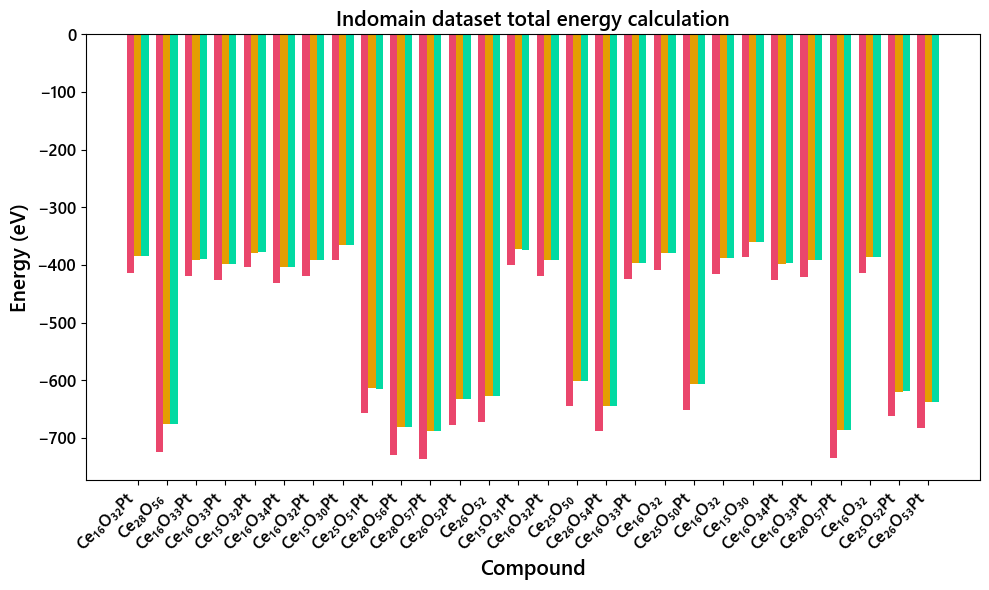

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


# Extracting the energies into separate lists
atoms_list = ["".join(details['atoms'].symbols) for details in structure_energy_dict.values()]
dft_energies = [details['dft_energy'] for details in structure_energy_dict.values()]
gemnet_energies = [details['gemnet_energy'] for details in structure_energy_dict.values()]
ft_e7_ep200_energies = [details['ft_e7_ep200_energy'] for details in structure_energy_dict.values()]
def subscript(text):
    subscripts = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    return text.translate(subscripts)

def format_chemical_formula(symbols_list):
    # Count the occurrences of each element
    element_counts = Counter(symbols_list)
    # Construct the formula by combining elements with their counts
    formula = "".join(f"{element}{count if count > 1 else ''}" for element, count in element_counts.items())
    return subscript(formula)

formatted_atoms_list = [format_chemical_formula(details['atoms'].get_chemical_symbols()) for details in structure_energy_dict.values()]

bar_width = 0.25
index = np.arange(len(structure_energy_dict))

plt.figure(figsize=(10, 6))
plt.bar(index, gemnet_energies, bar_width, color=colors[0], label='GemNet')
plt.bar(index + bar_width, ft_e7_ep200_energies, bar_width, color=colors[1], label='FT-GemNet')
plt.bar(index + 2 * bar_width, dft_energies, bar_width, color=colors[2], label='PBE+U')

plt.xlabel('Compound', fontproperties=font_properties)
plt.ylabel('Energy (eV)', fontproperties=font_properties)
plt.title('Indomain dataset total energy calculation', fontproperties=font_properties)
plt.xticks(index + bar_width, formatted_atoms_list, rotation=45, ha="right", fontproperties=font_properties)
plt.yticks(fontproperties=font_properties)
#plt.legend(prop=font_properties)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.tight_layout()
plt.savefig(savepath+'/all_trained_tot_e.png',dpi=1000)
plt.show()


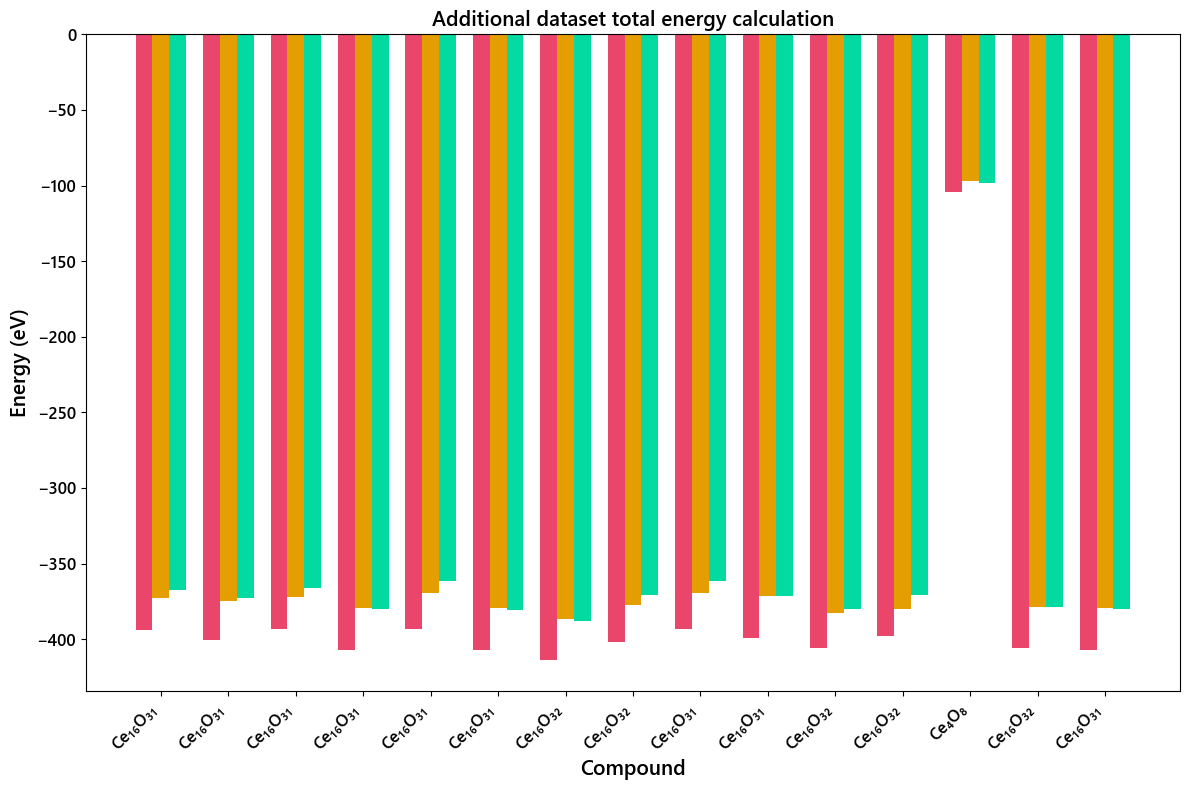

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

add_atoms_list = [details['atoms'].get_chemical_symbols() for details in add_structure_energy_dict.values()]
add_dft_energies = [details['dft_energy'] for details in add_structure_energy_dict.values()]
add_gemnet_energies = [details['gemnet_energy'] for details in add_structure_energy_dict.values()]
add_ft_e7_ep200_energies = [details['ft_e7_ep200_energy'] for details in add_structure_energy_dict.values()]


formatted_add_atoms_list = [format_chemical_formula(symbols) for symbols in add_atoms_list]

bar_width = 0.25
index = np.arange(len(add_structure_energy_dict))

plt.figure(figsize=(12, 8))
plt.bar(index, add_gemnet_energies, bar_width, color=colors[0], label='GemNet')
plt.bar(index + bar_width, add_ft_e7_ep200_energies, bar_width, color=colors[1], label='FT-GemNet')
plt.bar(index + 2 * bar_width, add_dft_energies, bar_width, color=colors[2], label='PBE+U')

plt.xlabel('Compound', fontproperties=font_properties)
plt.ylabel('Energy (eV)', fontproperties=font_properties)
plt.title('Additional dataset total energy calculation', fontproperties=font_properties)
plt.xticks(index + bar_width, formatted_add_atoms_list, rotation=45, ha="right", fontproperties=font_properties)
plt.yticks(fontproperties=font_properties)
#plt.legend(prop=font_properties)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.tight_layout()
plt.savefig(savepath+'/add_tot_e.png',dpi=1000)
plt.show()


### Ovac form (addtional database)

bulk_vac

In [ ]:
def read_contcars_bulk(folder_path,contcar_path):
    contcars_files = [f for f in os.listdir(contcar_path) if f.startswith('bulk')]
    contcar_dict = {}
    for file in contcars_files:
        identifier = file.split('_')[1]
        contcar_atoms = read_vasp(os.path.join(contcar_path, file))
        contcar_dict[identifier] = contcar_atoms
    return contcar_dict

folder_path = os.getcwd()
contcar_path = '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/bulk_vac'
bulk_dict = read_contcars_bulk(folder_path,contcar_path)

print(bulk_dict)
dft_energy_vac = -777.833236
dft_energy_clean = -785.588099

for key in bulk_dict:
    bulk_dict[key] = {
        'atoms': bulk_dict[key],
        'dft_energy': dft_energy_vac if key == 'vac' else dft_energy_clean
    }

for key, value in bulk_dict.items():
    print(f"Identifier: {key}, Atoms: {value['atoms']}, DFT Energy: {value['dft_energy']}")


{'vac': Atoms(symbols='Ce32O63', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]]), 'clean': Atoms(symbols='Ce32O64', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]])}
Identifier: vac, Atoms: Atoms(symbols='Ce32O63', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]]), DFT Energy: -777.833236
Identifier: clean, Atoms: Atoms(symbols='Ce32O64', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]]), DFT Energy: -785.588099


In [ ]:
def calculate_bulk_energies(bulk_dict, calculator):
    energy_dict = {}
    for identifier, structure_info in bulk_dict.items():
        atom = structure_info['atoms'].copy()
        tags = np.ones(len(atom))
        atom.set_tags(tags)
        atom.set_calculator(calculator)
        tot_energy = get_opt_energy(atom, fmax=0.05)  # Adjust fmax as needed
        energy_dict[identifier] = tot_energy
    return energy_dict

calculators = [calc_gemnet, calc_pt_ceo2_ce7_ep200]
calculator_names = ["gemnet", "ft_e7_ep200"]

for i, calc in enumerate(calculators):
    calc_name = calculator_names[i]

    bulk_energy_results = calculate_bulk_energies(bulk_dict, calc)

    for identifier in bulk_dict:
        bulk_dict[identifier][calc_name + '_energy'] = bulk_energy_results[identifier]
    print(f"Completed calculations with {calc_name}")

for identifier in bulk_dict:
    print(f"Identifier: {identifier}, Data: {bulk_dict[identifier]}")


       Step     Time          Energy         fmax
LBFGS:    0 05:35:11     -829.494080        0.2874
LBFGS:    1 05:35:11     -829.324341        0.1309
LBFGS:    2 05:35:11     -829.190247        0.0397
       Step     Time          Energy         fmax
LBFGS:    0 05:35:11     -835.359680        0.0165
Completed calculations with gemnet
       Step     Time          Energy         fmax
LBFGS:    0 05:35:11     -770.728210        0.0731
LBFGS:    1 05:35:11     -770.726562        0.0676
LBFGS:    2 05:35:11     -770.705139        0.0550
LBFGS:    3 05:35:11     -770.705200        0.0482
       Step     Time          Energy         fmax
LBFGS:    0 05:35:12     -778.547302        0.0287
Completed calculations with ft_e7_ep200
Identifier: vac, Data: {'atoms': Atoms(symbols='Ce32O63', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]]), 'dft_energy': -777.833236, 'gemnet_energy': -829.1902465820312, 'ft_e7_ep200_energy': -770.705

In [ ]:
bulk_dict

{'vac': {'atoms': Atoms(symbols='Ce32O63', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]]),
  'dft_energy': -777.833236,
  'gemnet_energy': -829.1902465820312,
  'ft_e7_ep200_energy': -770.7052001953125},
 'clean': {'atoms': Atoms(symbols='Ce32O64', pbc=True, cell=[[11.1426944733, 0.0, 0.0], [0.0, 11.1426868439, 0.0], [2.9675e-06, -8.9024e-06, 11.1426906586]]),
  'dft_energy': -785.588099,
  'gemnet_energy': -835.3596801757812,
  'ft_e7_ep200_energy': -778.5473022460938}}

In [ ]:
add_facet_info = {
    '0': 'bulk',
    '1': '111_clean',
    '2': '111_vac',
    '3': '111_vac',
    '4': '111_vac',
    '5': '100_clean',
    '6': '100_vac',
    '7': '110_clean',
    '8': '110_vac',
    '9': '221_clean',
    '10': '221_vac',
    '11': '221_vac',
    '12': '210_clean',
    '13': '210_vac',
    '14': '210_vac'
}

for identifier, data in add_structure_energy_dict.items():
    facet_description = add_facet_info.get(identifier, "Unknown facet")
    data['facet_description'] = facet_description
for identifier, data in add_structure_energy_dict.items():
    print(f"Identifier: {identifier}, Facet: {data['facet_description']}, Data: {data}")


Identifier: 13, Facet: 210_vac, Data: {'atoms': Atoms(symbols='Ce16O31', pbc=True, cell=[[5.5713448524, 0.0, 0.0], [-5.571336162, 12.4579050921, 0.0], [0.0, -2.491595805, 29.8989832441]], tags=..., constraint=FixAtoms(indices=[8, 9, 10, 11, 12, 13, 14, 15, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]), calculator=OCPCalculator(...)), 'dft_energy': -367.245781, 'ft_e7_ep200_energy': -372.89111328125, 'gemnet_energy': -394.0235595703125, 'facet_description': '210_vac'}
Identifier: 8, Facet: 110_vac, Data: {'atoms': Atoms(symbols='Ce16O31', pbc=True, cell=[11.14441270360164, 7.8803586320414425, 16.04698099759775], tags=..., constraint=FixAtoms(indices=[2, 3, 6, 7, 10, 11, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]), calculator=OCPCalculator(...)), 'dft_energy': -372.786456, 'ft_e7_ep200_energy': -374.8872985839844, 'gemnet_energy': -400.35394287109375, 'facet_description': '110_vac'}
Identifier: 14, Facet: 210_vac, Data: {'atoms': Atoms(symb

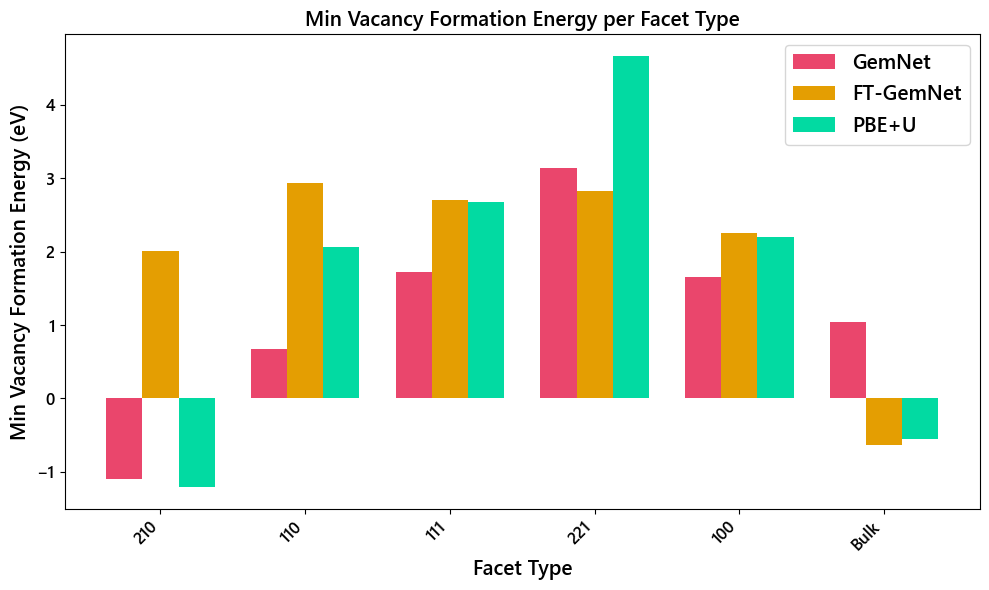

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

oxygen_energy = -7.204 #taken from OC project https://pubs.acs.org/doi/suppl/10.1021/acscatal.0c04525/suppl_file/cs0c04525_si_001.pdf
dft_oxygen_energy = -.98584855E+01/2

# Group energies by facet type
def group_energies_by_facet_type(data_dict, energy_key):
    grouped_energies = {}
    for identifier, data in data_dict.items():
        facet_type = data['facet_description'].split('_')[0]  # Extract facet type (e.g., '111', '100')
        if facet_type not in grouped_energies:
            grouped_energies[facet_type] = {'clean': None, 'vac': []}
        if 'clean' in data['facet_description']:
            grouped_energies[facet_type]['clean'] = data[energy_key]
        elif 'vac' in data['facet_description']:
            grouped_energies[facet_type]['vac'].append(data[energy_key])
    return grouped_energies

# Grouping energies for each calculator
dft_grouped_energies = group_energies_by_facet_type(add_structure_energy_dict, 'dft_energy')
gemnet_grouped_energies = group_energies_by_facet_type(add_structure_energy_dict, 'gemnet_energy')
ft_grouped_energies = group_energies_by_facet_type(add_structure_energy_dict, 'ft_e7_ep200_energy')

# Calculate min vacancy formation energy for each facet type
def calc_avg_vac_formation_energy(grouped_energies):
    vac_formation_energies = {}
    for facet_type, energies in grouped_energies.items():
        if energies['clean'] is not None and energies['vac']:
            min_vac_energy = np.min(energies['vac'])
            vac_formation_energy =  min_vac_energy + dft_oxygen_energy - energies['clean']
            vac_formation_energies[facet_type] = vac_formation_energy
    return vac_formation_energies

dft_vac_formation_energies = calc_avg_vac_formation_energy(dft_grouped_energies)
gemnet_vac_formation_energies = calc_avg_vac_formation_energy(gemnet_grouped_energies)
ft_vac_formation_energies = calc_avg_vac_formation_energy(ft_grouped_energies)


def calc_bulk_vac_formation_energy(bulk_dict, energy_key):
    clean_energy = bulk_dict['clean'][energy_key]
    vac_energy = bulk_dict['vac'][energy_key]
    return  clean_energy -vac_energy - oxygen_energy

# Calculate bulk vacancy formation energies
bulk_vac_formation_energy_dft = calc_bulk_vac_formation_energy(bulk_dict, 'dft_energy')
bulk_vac_formation_energy_gemnet = calc_bulk_vac_formation_energy(bulk_dict, 'gemnet_energy')
bulk_vac_formation_energy_ft = calc_bulk_vac_formation_energy(bulk_dict, 'ft_e7_ep200_energy')

bar_width = 0.25
index = np.arange(len(dft_vac_formation_energies) + 1)  # +1 for bulk

plt.figure(figsize=(10, 6))
plt.bar(index[:-1], list(gemnet_vac_formation_energies.values()), bar_width, color=colors[0], label='GemNet')
plt.bar(index[:-1] + bar_width, list(ft_vac_formation_energies.values()), bar_width, color=colors[1], label='FT-GemNet')
plt.bar(index[:-1] + 2 * bar_width, list(dft_vac_formation_energies.values()), bar_width, color=colors[2], label='PBE+U')

# Add bulk vacancy formation energies for each calculator
plt.bar(index[-1], bulk_vac_formation_energy_gemnet, bar_width, color=colors[0])
plt.bar(index[-1] + bar_width, bulk_vac_formation_energy_ft, bar_width, color=colors[1])
plt.bar(index[-1] + 2 * bar_width, bulk_vac_formation_energy_dft, bar_width, color=colors[2])

facet_types = list(dft_vac_formation_energies.keys()) + ['Bulk']

plt.xlabel('Facet Type', fontproperties=font_properties)
plt.ylabel('Min Vacancy Formation Energy (eV)', fontproperties=font_properties)
plt.title('Min Vacancy Formation Energy per Facet Type', fontproperties=font_properties)
plt.xticks(index + bar_width, facet_types, rotation=45, ha="right", fontproperties=font_properties)
plt.yticks(fontproperties=font_properties)
#plt.legend(prop=font_properties)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.tight_layout()
plt.savefig(savepath+'/Ovac_e.png',dpi=1000)

plt.show()


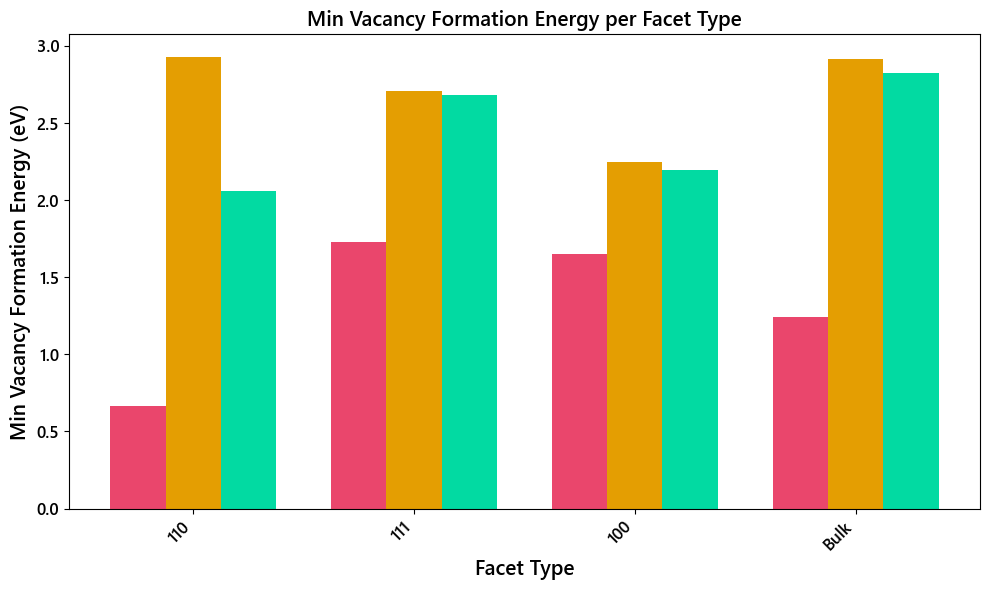

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#oxygen_energy = -7.204  # Taken from OC project
oxygen_energy = -0.98584855E+01 / 2  # Adjusted oxygen energy for DFT -7.4626881

# Group energies by facet type
def group_energies_by_facet_type(data_dict, energy_key):
    grouped_energies = {}
    for identifier, data in data_dict.items():
        facet_type = data['facet_description'].split('_')[0]
        if facet_type not in grouped_energies:
            grouped_energies[facet_type] = {'clean': None, 'vac': []}
        if 'clean' in data['facet_description']:
            grouped_energies[facet_type]['clean'] = data[energy_key]
        elif 'vac' in data['facet_description']:
            grouped_energies[facet_type]['vac'].append(data[energy_key])
    return grouped_energies

# Grouping energies for each calculator
dft_grouped_energies = group_energies_by_facet_type(add_structure_energy_dict, 'dft_energy')
gemnet_grouped_energies = group_energies_by_facet_type(add_structure_energy_dict, 'gemnet_energy')
ft_grouped_energies = group_energies_by_facet_type(add_structure_energy_dict, 'ft_e7_ep200_energy')

# Calculate min vacancy formation energy for each facet type
def calc_avg_vac_formation_energy(grouped_energies, oxygen_energy):
    vac_formation_energies = {}
    for facet_type, energies in grouped_energies.items():
        if energies['clean'] is not None and energies['vac']:
            min_vac_energy = np.min(energies['vac'])
            vac_formation_energy = min_vac_energy - energies['clean'] + oxygen_energy
            vac_formation_energies[facet_type] = vac_formation_energy
    return vac_formation_energies

def filter_facet_types(energy_dict, excluded_facets):
    return {facet: energy for facet, energy in energy_dict.items() if facet not in excluded_facets}

excluded_facets = ['221', '210']


dft_vac_formation_energies = calc_avg_vac_formation_energy(dft_grouped_energies, oxygen_energy)
gemnet_vac_formation_energies = calc_avg_vac_formation_energy(gemnet_grouped_energies, oxygen_energy)
ft_vac_formation_energies = calc_avg_vac_formation_energy(ft_grouped_energies, oxygen_energy)

dft_vac_formation_energies = filter_facet_types(dft_vac_formation_energies, excluded_facets)
gemnet_vac_formation_energies = filter_facet_types(gemnet_vac_formation_energies, excluded_facets)
ft_vac_formation_energies = filter_facet_types(ft_vac_formation_energies, excluded_facets)



# Function to calculate bulk vacancy formation energy
def calc_bulk_vac_formation_energy(bulk_dict, energy_key, oxygen_energy):
    clean_energy = bulk_dict['clean'][energy_key]
    vac_energy = bulk_dict['vac'][energy_key]
    return vac_energy - clean_energy + oxygen_energy

# Calculate bulk vacancy formation energies
bulk_vac_formation_energy_dft = calc_bulk_vac_formation_energy(bulk_dict, 'dft_energy', oxygen_energy)
bulk_vac_formation_energy_gemnet = calc_bulk_vac_formation_energy(bulk_dict, 'gemnet_energy', oxygen_energy)
bulk_vac_formation_energy_ft = calc_bulk_vac_formation_energy(bulk_dict, 'ft_e7_ep200_energy', oxygen_energy)

bar_width = 0.25
index = np.arange(len(dft_vac_formation_energies) + 1)  # +1 for bulk

plt.figure(figsize=(10, 6))
plt.bar(index[:-1], list(gemnet_vac_formation_energies.values()), bar_width, color=colors[0], label='GemNet')
plt.bar(index[:-1] + bar_width, list(ft_vac_formation_energies.values()), bar_width, color=colors[1], label='FT-GemNet')
plt.bar(index[:-1] + 2 * bar_width, list(dft_vac_formation_energies.values()), bar_width, color=colors[2], label='PBE+U')

# Add bulk vacancy formation energies for each calculator
plt.bar(index[-1], bulk_vac_formation_energy_gemnet, bar_width, color=colors[0])
plt.bar(index[-1] + bar_width, bulk_vac_formation_energy_ft, bar_width, color=colors[1])
plt.bar(index[-1] + 2 * bar_width, bulk_vac_formation_energy_dft, bar_width, color=colors[2])

facet_types = list(dft_vac_formation_energies.keys()) + ['Bulk']

plt.xlabel('Facet Type', fontproperties=font_properties)
plt.ylabel('Min Vacancy Formation Energy (eV)', fontproperties=font_properties)
plt.title('Min Vacancy Formation Energy per Facet Type', fontproperties=font_properties)
plt.xticks(index + bar_width, facet_types, rotation=45, ha="right", fontproperties=font_properties)
plt.yticks(fontproperties=font_properties)
#plt.legend(prop=font_properties)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.tight_layout()
plt.savefig(savepath+'/Ovac_selected.png',dpi=1000)

plt.show()

Surface energy

<ipython-input-35-82120012e2ba>:50: UserWarning: Glyph 8491 (\N{ANGSTROM SIGN}) missing from current font.
  plt.tight_layout()
<ipython-input-35-82120012e2ba>:51: UserWarning: Glyph 8491 (\N{ANGSTROM SIGN}) missing from current font.
  plt.savefig(savepath+'/SurfE_selected.png',dpi=1000)


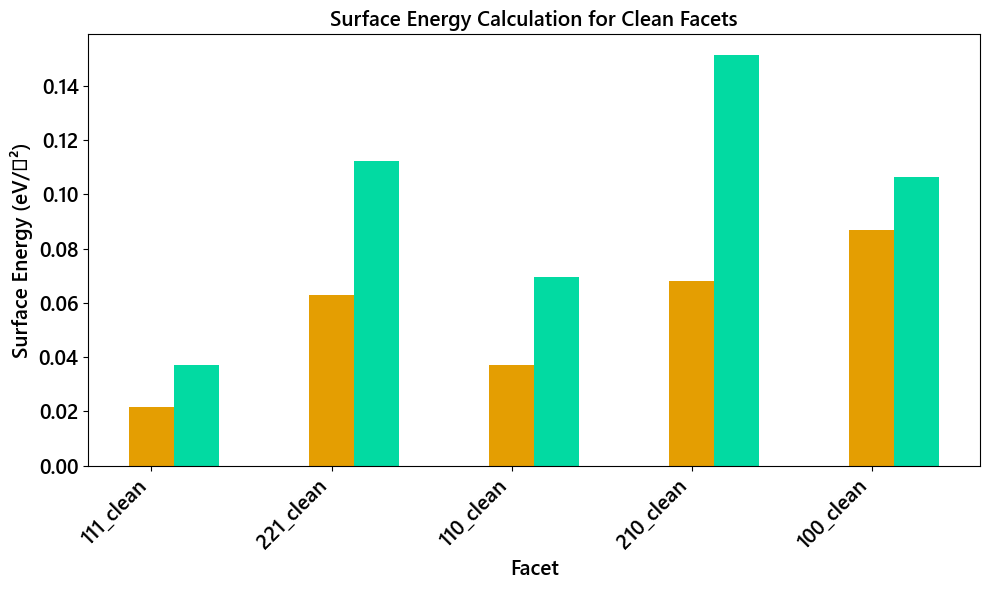

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate surface area of a cell
def calculate_surface_area(cell):
    return np.linalg.norm(np.cross(cell[0], cell[1]))

# Extract bulk energy for each calculator
bulk_energy_dft = add_structure_energy_dict['0']['dft_energy']
bulk_energy_gemnet = add_structure_energy_dict['0']['gemnet_energy']
bulk_energy_ft = add_structure_energy_dict['0']['ft_e7_ep200_energy']

dft_surf_energies = []
gemnet_surf_energies = []
ft_surf_energies = []
facets = []

for identifier, data in add_structure_energy_dict.items():
    if identifier != '0' and 'clean' in data['facet_description']:  # Exclude bulk and vac facets
        facets.append(data['facet_description'])
        area = calculate_surface_area(data['atoms'].cell)*2

        slab_energy_dft = data['dft_energy']
        slab_energy_gemnet = data['gemnet_energy']
        slab_energy_ft = data['ft_e7_ep200_energy']

        dft_surf_energy = (slab_energy_dft - bulk_energy_dft * 4) / area
        gemnet_surf_energy = (slab_energy_gemnet - bulk_energy_gemnet * 4) / area
        ft_surf_energy = (slab_energy_ft - bulk_energy_ft * 4) / area
        dft_surf_energies.append(dft_surf_energy)
        gemnet_surf_energies.append(gemnet_surf_energy)
        ft_surf_energies.append(ft_surf_energy)


bar_width = 0.25
index = np.arange(len(facets))

# Plotting
plt.figure(figsize=(10, 6))
#plt.bar(index , gemnet_surf_energies, bar_width, color=colors[0], label='GemNet')
plt.bar(index + bar_width, ft_surf_energies, bar_width, color=colors[1], label='FT-GemNet')
plt.bar(index + 2 * bar_width, dft_surf_energies, bar_width, color=colors[2], label='PBE+U')

plt.xlabel('Facet', fontproperties=font_properties)
plt.ylabel('Surface Energy (eV/Å²)', fontproperties=font_properties)
plt.title('Surface Energy Calculation for Clean Facets', fontproperties=font_properties)
plt.xticks(index + bar_width, facets, rotation=45, ha="right", fontproperties=font_properties)
plt.yticks(fontproperties=font_properties)
#plt.legend()
plt.tight_layout()
plt.savefig(savepath+'/SurfE_selected.png',dpi=1000)
plt.show()


Modified DFT Surface Energies: {'111': 0.03694022399725259, '221': 0.11224684750545677, '110': 0.06948603612578598, '210': 0.15135396001249246, '100': 0.10650754067431367}
Modified GemNet Surface Energies: {'111': 0.03756111492969509, '221': 0.08688281876593675, '110': 0.06743896496928076, '210': 0.14359431637239775, '100': 0.09893257158283503}
Modified FT Surface Energies: {'111': 0.02161542285436374, '221': 0.06301039937935447, '110': 0.037060025992818706, '210': 0.06794109093636291, '100': 0.08624326781841536}


evaluation warm start comparison

In [ ]:
!ls /content/drive/MyDrive/0_doctoral_project/1_pt_ceox/pt_ceox_evaluation_data

add_warm_start	ft_warm_start_input  initial_generated	o_vac_left_over


In [ ]:
import os

def read_contcars_eval(folder_path, contcar_path):
    contcars_files = [f for f in os.listdir(contcar_path) if f.endswith('vasp')]
    contcar_dict = {}
    for file in contcars_files:
        identifier = f"{file}"
        contcar_atoms = read_vasp(os.path.join(contcar_path, file))
        contcar_dict[identifier] = {'atoms': contcar_atoms, 'dft_energy': None}
    return contcar_dict

folder_path = os.getcwd()
eval_structures_path = '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/pt_ceox_evaluation_data'
eval_structures_dict = read_contcars_eval(folder_path, eval_structures_path)


def status(proceed):
    num = int(proceed/5)
    return '🟩'*num+'⬜️'*(20-num)
#proceed = round((i+1) / len(selected_names) * 100, 2)
#print(status(proceed))

count=0



In [ ]:
def calculate_bulk_energies(eval_structures_dict, calculator, energy_results_dict):
    for identifier, structure_info in eval_structures_dict.items():
        if identifier not in energy_results_dict:  # Process only if not already done
            atom = structure_info['atoms']
            tags = np.ones(len(atom))
            atom.set_tags(tags)
            atom.set_calculator(calculator)
            tot_energy = get_opt_energy(atom, fmax=0.05)  # Adjust fmax as needed
            energy_results_dict[identifier] = tot_energy

energy_results_dict = {}  # Dictionary to store the results
calculators = [calc_pt_ceo2_ce7_ep200]
calculator_names = ["ft_e7_ep200"]

for i, calc in enumerate(calculators):
    calc_name = calculator_names[i]
    calculate_bulk_energies(eval_structures_dict, calc, energy_results_dict)
    for identifier in eval_structures_dict:
        eval_structures_dict[identifier][calc_name + '_energy'] = energy_results_dict[identifier]

# Print results
for identifier in eval_structures_dict:
    print(f"Identifier: {identifier}, Data: {eval_structures_dict[identifier]}")


In [ ]:
!sudo apt-get install povray  ## visulization program

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,792 kB of archives.
After this operation, 5,199 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-povray all 1:3.7.0.10-1 [70.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-6 [177 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray amd64 1:3.7.0.10-1 [1,312 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 povray-includes all 1:3.7.0.10-1 [233 kB]
Fetched 1,792 kB in 1s (2,144 kB/s)
debconf: unable to initialize frontend: Dialo

In [ ]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ase import Atoms
from ase.build import fcc111, add_adsorbate, bulk
from ase.io import read, write
from PIL import Image
from IPython.display import display
import shutil
import os

def visual(structure, index, max_size=(100, 100), stretch_y=1.0):
    renderer = write('./temp.pov', structure, rotation='20z,-35x')
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)

    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/temp/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)


In [ ]:
from ase import Atoms
from ase.io.vasp import write_vasp

for identifier, data in eval_structures_dict.items():
    if isinstance(data['atoms'], Atoms):
        print(f"Identifier: {identifier}, Atoms: {data['atoms']}")
        #print(data['atoms'].get_total_energy())
        #visual(data['atoms'], f'./ini_', (100, 100), 1)
        print(data['atoms'].symbols)
        #write_vasp(f'/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/pt_ceox_evaluation_data/ft_warm_start_input/relaxed_{identifier}',data['atoms'])

In [ ]:
ovac_structures_path = '/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/pt_ceox_evaluation_data/o_vac_left_over'
ovac_structures_dict = read_contcars_eval(folder_path, ovac_structures_path)


In [ ]:
def calculate_bulk_energies(ovac_structures_dict, calculator, energy_results_dict):
    for identifier, structure_info in ovac_structures_dict.items():
        if identifier not in energy_results_dict:  # Process only if not already done
            atom = structure_info['atoms']
            tags = np.ones(len(atom))
            atom.set_tags(tags)
            atom.set_calculator(calculator)
            tot_energy = get_opt_energy(atom, fmax=0.05)  # Adjust fmax as needed
            energy_results_dict[identifier] = tot_energy

energy_results_dict = {}  # Dictionary to store the results
calculators = [calc_pt_ceo2_ce7_ep200]
calculator_names = ["ft_e7_ep200"]

for i, calc in enumerate(calculators):
    calc_name = calculator_names[i]
    calculate_bulk_energies(ovac_structures_dict, calc, energy_results_dict)
    for identifier in ovac_structures_dict:
        ovac_structures_dict[identifier][calc_name + '_energy'] = energy_results_dict[identifier]

# Print results
for identifier in ovac_structures_dict:
    print(f"Identifier: {identifier}, Data: {ovac_structures_dict[identifier]}")


       Step     Time          Energy         fmax
LBFGS:    0 10:50:55     -556.263062        3.3600
LBFGS:    1 10:50:55     -556.721924        3.1797
LBFGS:    2 10:50:55     -558.027344        1.2876
LBFGS:    3 10:50:55     -558.284363        2.1043
LBFGS:    4 10:50:55     -558.359375        1.4981
LBFGS:    5 10:50:55     -558.305603        0.9255
LBFGS:    6 10:50:55     -558.181580        1.1263
LBFGS:    7 10:50:55     -558.103027        1.1395
LBFGS:    8 10:50:56     -558.134399        1.0439
LBFGS:    9 10:50:56     -558.250549        0.8706
LBFGS:   10 10:50:56     -558.358826        0.5617
LBFGS:   11 10:50:56     -558.392639        0.8378
LBFGS:   12 10:50:56     -558.386230        0.9889
LBFGS:   13 10:50:56     -558.394104        0.8685
LBFGS:   14 10:50:56     -558.292175        0.5695
LBFGS:   15 10:50:56     -558.229797        0.5078
LBFGS:   16 10:50:56     -558.197266        0.6601
LBFGS:   17 10:50:56     -558.229065        0.5543
LBFGS:   18 10:50:57     -558.25

Identifier: 2_223.vasp, Atoms: Atoms(symbols='Ce24O47', pbc=True, cell=[[7.8790721893, 0.0, 0.0], [0.0, 16.2431259155, 0.0], [2.35127e-05, -6.6883472279, 24.3224914728]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]), calculator=OCPCalculator(...))
-558.3515014648438


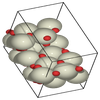

Ce24O47
Identifier: 1_112.vasp, Atoms: Atoms(symbols='Ce24O47', pbc=True, cell=[[11.818608284, 0.0, 0.0], [1.285e-06, 9.64985466, 0.0], [2.90752e-05, -3.6344e-06, 27.2939014435]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 56, 57, 58, 59, 60, 61, 62, 63]), calculator=OCPCalculator(...))
-562.8052978515625


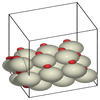

Ce24O47
Identifier: 3_331.vasp, Atoms: Atoms(symbols='Ce24O47', pbc=True, cell=[[7.8790721893, 0.0, 0.0], [3.9395267733, 17.1720400661, 0.0], [1.9697487332, 3.1632640963, 23.0067741798]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 6, 7, 8, 12, 13, 14, 18, 19, 20, 24, 25, 26, 27, 28, 29, 36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 52, 53, 60, 61, 62, 63, 64, 65]), calculator=OCPCalculator(...))
-554.1731567382812


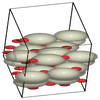

Ce24O47


In [ ]:
from ase import Atoms
from ase.io.vasp import write_vasp

for identifier, data in ovac_structures_dict.items():
    if isinstance(data['atoms'], Atoms):
        print(f"Identifier: {identifier}, Atoms: {data['atoms']}")
        print(data['atoms'].get_total_energy())
        visual(data['atoms'], f'./ini_', (100, 100), 1)
        print(data['atoms'].symbols)
        write_vasp(f'/content/drive/MyDrive/0_doctoral_project/1_pt_ceox/pt_ceox_evaluation_data/ft_warm_start_input/relaxed_vac_{identifier}',data['atoms'])

temp, thermo dependent wulff --> GA concept ?
wulff still looks the same tho...,... in https://nanocrystal.vi-seem.eu/CrystalTool/downloads.php?fileName=CeO2_11182023060820

using surfypy for phase diagram generation?
https://github.com/symmy596/SurfinPy

Pt anchoring

https://static-content.springer.com/esm/art%3A10.1038%2Fs41929-020-00508-7/MediaObjects/41929_2020_508_MOESM1_ESM.pdf

Pt anchoring gibbs free energy then the problem is O2 energy

wulff




```
import numpy as np
from pymatgen.core.surface import Structure, Lattice
from pymatgen.analysis.wulff import WulffShape
# Function to modify keys
def modify_keys(original_dict):
    return {key.replace('_clean', ''): value for key, value in original_dict.items()}

# Initialize dictionaries
dft_surf_energy_dict = {}
gemnet_surf_energy_dict = {}
ft_surf_energy_dict = {}

# Populate dictionaries and modify keys
for i, facet in enumerate(facets):
    dft_surf_energy_dict[facet.replace('_clean', '')] = dft_surf_energies[i]
    gemnet_surf_energy_dict[facet.replace('_clean', '')] = gemnet_surf_energies[i]
    ft_surf_energy_dict[facet.replace('_clean', '')] = ft_surf_energies[i]

# Print the dictionaries to check
print("Modified DFT Surface Energies:", dft_surf_energy_dict)
print("Modified GemNet Surface Energies:", gemnet_surf_energy_dict)
print("Modified FT Surface Energies:", ft_surf_energy_dict)

# Create the structure
lattice = Lattice.cubic(5.411)
ceo = Structure(lattice, ["Ce", "O"], [[0, 0, 0], [0.25, 0.25, 0.25]])

# Define surface energies from each calculator
surface_energies_dft = {(1, 1, 1): dft_surf_energy_dict['111'],
                        (1, 1, 0): dft_surf_energy_dict['110'],
                        (1, 0, 0): dft_surf_energy_dict['100']}

surface_energies_gemnet = {(1, 1, 1): gemnet_surf_energy_dict['111'],
                           (1, 1, 0): gemnet_surf_energy_dict['110'],
                           (1, 0, 0): gemnet_surf_energy_dict['100']}

surface_energies_ft = {(1, 1, 1): ft_surf_energy_dict['111'],
                       (1, 1, 0): ft_surf_energy_dict['110'],
                       (1, 0, 0): ft_surf_energy_dict['100']}

wulffshape_dft = WulffShape(ceo.lattice, surface_energies_dft.keys(), surface_energies_dft.values())
wulffshape_gemnet = WulffShape(ceo.lattice, surface_energies_gemnet.keys(), surface_energies_gemnet.values())
wulffshape_ft = WulffShape(ceo.lattice, surface_energies_ft.keys(), surface_energies_ft.values())

wulffshape_dft.show(color_set="RdBu", direction=(1.00, 0.25, 0.25))
wulffshape_gemnet.show(color_set="RdBu", direction=(1.00, 0.25, 0.25))
wulffshape_ft.show(color_set="RdBu", direction=(1.00, 0.25, 0.25))```



## Scaliability

The total energy prediction is quite off. i will try adsorption of Pt energy comparison